In [1]:
import os, sys, time
sys.path.append("../src")

from tqdm import tqdm
import numpy as np
import torch
import argparse
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

2025-01-09 04:52:10.734402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 04:52:12.680241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-09 04:52:12.680410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-01-09 04:52:12.680432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [13]:
def plot_proba_diff(ds_name, num_labels, save_dir, used_column):
    diff_enh_lst, diff_sup_lst = [], []
    diff_enh_lst_vscore, diff_sup_lst_vscore = [], []
    
    diff_enh_lst_random, diff_sup_lst_random = [], []
    for tgt_label in range(num_labels):
        ori_proba = np.load(os.path.join(save_dir, f"{used_column}_proba_{tgt_label}.npy"))[:, tgt_label]
        enh_proba = np.load(os.path.join(save_dir, f"{used_column}_proba_ig_list_l9tol12_enhance_{tgt_label}.npy"))[:, tgt_label]
        sup_proba = np.load(os.path.join(save_dir, f"{used_column}_proba_ig_list_l9tol12_suppress_{tgt_label}.npy"))[:, tgt_label]
        enh_proba_vscore = np.load(os.path.join(save_dir, f"{used_column}_proba_vscore_l9tol12_enhance_{tgt_label}.npy"))[:, tgt_label]
        sup_proba_vscore = np.load(os.path.join(save_dir, f"{used_column}_proba_vscore_l9tol12_suppress_{tgt_label}.npy"))[:, tgt_label]
        enh_proba_random = np.load(os.path.join(save_dir, f"{used_column}_proba_random_l9tol12_enhance_{tgt_label}.npy"))[:, tgt_label]
        sup_proba_random = np.load(os.path.join(save_dir, f"{used_column}_proba_random_l9tol12_suppress_{tgt_label}.npy"))[:, tgt_label]
        # 差分を計算
        diff_enh = enh_proba - ori_proba
        diff_sup = sup_proba - ori_proba
        diff_enh_lst.append(diff_enh)
        diff_sup_lst.append(diff_sup)
        diff_enh = enh_proba_vscore - ori_proba
        diff_sup = sup_proba_vscore - ori_proba
        diff_enh_lst_vscore.append(diff_enh)
        diff_sup_lst_vscore.append(diff_sup)
        diff_enh = enh_proba_random - ori_proba
        diff_sup = sup_proba_random - ori_proba
        diff_enh_lst_random.append(diff_enh)
        diff_sup_lst_random.append(diff_sup)
    diff_enh_lst = np.array(diff_enh_lst)
    diff_sup_lst = np.array(diff_sup_lst)
    diff_enh_lst_vscore = np.array(diff_enh_lst_vscore)
    diff_sup_lst_vscore = np.array(diff_sup_lst_vscore)
    diff_enh_lst_random = np.array(diff_enh_lst_random)
    diff_sup_lst_random = np.array(diff_sup_lst_random)
    print(f"kn {'='*60}")
    print(f"avg. enh. prob. diff. = {diff_enh_lst.mean()*100} (%)")
    print(f"avg. sup. prob. diff. = {diff_sup_lst.mean()*100} (%)")
    print(f"vn {'='*60}")
    print(f"avg. enh. prob. diff. = {diff_enh_lst_vscore.mean()*100} (%)")
    print(f"avg. sup. prob. diff. = {diff_sup_lst_vscore.mean()*100} (%)")
    print(f"rn {'='*60}")
    print(f"avg. enh. prob. diff. = {diff_enh_lst_random.mean()*100} (%)")
    print(f"avg. sup. prob. diff. = {diff_sup_lst_random.mean()*100} (%)")
    # diff_enh_lstを1軸目方向に平均してプロット
    plt.figure(figsize=(8, 6))
    plt.plot(diff_enh_lst.mean(axis=1)*100, label="Enhance (kn)", color="red")
    plt.plot(diff_sup_lst.mean(axis=1)*100, label="Suppress (kn)", color="blue")
    plt.plot(diff_enh_lst_vscore.mean(axis=1)*100, label="Enhance (vn)", color="orange")
    plt.plot(diff_sup_lst_vscore.mean(axis=1)*100, label="Suppress (vn)", color="lightblue")
    plt.plot(diff_enh_lst_random.mean(axis=1)*100, label="Enhance (random)", color="green")
    plt.plot(diff_sup_lst_random.mean(axis=1)*100, label="Suppress (random)", color="yellow")
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Class Label")
    plt.ylabel("Average Change of Probability (%)")
    plt.legend()
    plt.show()

diff_enh_lst_random.shape = (100,)
diff_sup_lst_random.shape = (100,)
kn ============================================================
avg. enh. prob. diff. = 0.22300654090940952 (%)
avg. sup. prob. diff. = -5.844159051775932 (%)
vn ============================================================
avg. enh. prob. diff. = -0.16932727303355932 (%)
avg. sup. prob. diff. = -6.00886195898056 (%)
rn ============================================================
avg. enh. prob. diff. = -0.037290825275704265 (%)
avg. sup. prob. diff. = -0.07289877394214272 (%)


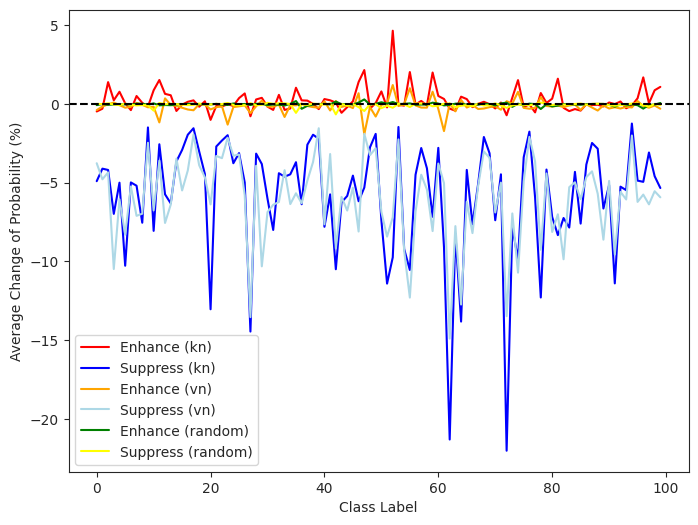

In [14]:
# 100ラベルにかかった時間: 4715.700sec
ds_name = "c100"
num_labels = 100
save_dir = os.path.join("/src/src/out_vit_c100", "pred_results")
used_column = "train"
plot_proba_diff(ds_name, num_labels, save_dir, used_column)